In [ ]:
! pip install --upgrade ultralytics -qq
!pip install GPUtil -qq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 16.7 MB/s eta 0:00:00


In [ ]:
!pip install pytesseract

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import re
import glob
import subprocess
import random
import yaml
import tqdm
import gc


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from IPython.display import Video
from PIL import Image
import cv2

import ultralytics
from ultralytics import YOLO

import easyocr

import xml.etree.ElementTree as xet
from bs4 import BeautifulSoup

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import pytesseract

print('ultralytics version: ',ultralytics.__version__)

ultralytics version:  8.0.230


In [ ]:
class CFG:
    #paths
    out_folder = f'/content/drive/MyDrive/Colab Notebooks'
    class_name = ['car_plate']
    weights = 'yolov8s.pt'
    exp_name = 'car_plate_detection'
    img_size = (240,400)
    vehicles_class = [2, 3, 5, 7]

    #Yolo train parameters
    epochs = 50
    batch_size = 16
    optimizer = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    lr = 1e-5
    lr_factor = 0.01 #lo*lr_f
    weight_decay = 5e-4
    dropout = 0.5
    patience = int(0.7*epochs)
    profile = False
    label_smoothing = 0.0

    #models Confidance
    vehicle_conf = 0.5
    plate_conf = 0.3
    ocr_conf = 0.05
    seed = 42




In [ ]:
def get_bbox(file_path):
    '''
    This function takes a file path as input.
    It extracts information about the bounding box (coordinates) from the XML file, specifically the values for xmin, xmax, ymin, and ymax.
    Returns a tuple containing the extracted coordinates (xmin, xmax, ymin, ymax).
    '''
    info = xet.parse(file_path)
    root = info.getroot()
    member_object = root.find('object')

    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    return  xmin, xmax, ymin, ymax



def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.seed):
    '''
    It randomly selects num_images image files from the specified folder.
    It then plots the image with the bounding box using Matplotlib, arranging the images in a grid.
    '''
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]



    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        img = cv2.imread(os.path.join(folder_path, file_name))


        xmin, xmax, ymin, ymax = get_bbox(file_path=os.path.join('/content/drive/MyDrive/Colab Notebooks/Datapj1/annotations',
                                                                 file_name.replace('.png','.xml')))



        start_point = (xmin, ymax)
        end_point = (xmax, ymin)

        img = cv2.rectangle(img, start_point, end_point, (255,0,0), 3)


        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

def parse_xml_tags(data):
    """Parse xml label file, return image file name, and its coordinates as a dictionary
    """
    tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    Bs_data = BeautifulSoup(data, "xml")
    d = dict()

    for t in tags:
        text = Bs_data.find(t).text
        if all(c.isdigit() for c in text):
            d[t] = int(text)
        else:
            d[t] = text
    return d




def convert_xml_txt_yolo(file_path,w_image,h_image):
    '''
    This function converts XML label information to YOLO format.
    It reads an XML file specified by the file path, extracts bounding box coordinates, and converts them to YOLO format.
    Returns a string in YOLO format
    '''
    with open(file_path,  'r') as f:
        label = parse_xml_tags(f.read())


    xmin = int(label['xmin'])
    xmax = int(label['xmax'])
    ymin = int(label['ymin'])
    ymax = int(label['ymax'])


    x_center = float((xmin+((xmax-xmin)/2))/w_image)
    y_center = float((ymin+((ymax-ymin)/2))/h_image)

    width = float((xmax-xmin)/w_image)
    height = float((ymax-ymin)/h_image)

    str_out = f'0 {x_center} {y_center} {width} {height}'

    return str_out

def display_image(image, print_info = True, hide_axis = False, figsize = (15,15), title=None):
    '''
    This function displays an image using Matplotlib.
    It takes an image file path or a NumPy array as input.
    It can print information about the image (type and shape), hide axis, and set a title.
    '''
    fig = plt.figure(figsize = figsize)
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)

        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        if image.shape[-1] == 3:
            image = image[..., ::-1]  # BGR to RGB
            img = Image.fromarray(image)
            plt.imshow(img)
        else:
            img = np.copy(image)
            plt.imshow(img,cmap = 'gray')

    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

def create_dir(path):
    '''
    This function creates a directory at the specified path if it doesn't exist.
    '''
    if not os.path.exists(path):
        os.mkdir(path)

def gpu_report():
    '''
    This function provides information about the available GPUs, their properties, and CUDA version.
    It also prints GPU usage.
    '''
    if torch.cuda.is_available():
        # Get the number of available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"Number of available GPUs: {num_gpus}")

        if num_gpus > 1:
            train_device, test_device = 0,1

        else:
            train_device, test_device = 0,0




        # Get information about each GPU
        for i in range(num_gpus):
            gpu_properties = torch.cuda.get_device_properties(i)
            print(f"\nGPU {i}: {gpu_properties.name}")
            print(f"  Total Memory: {gpu_properties.total_memory / (1024**3):.2f} GB")
            print(f"  CUDA Version: {gpu_properties.major}.{gpu_properties.minor}")


    else:
        print("CUDA is not available. You can only use CPU.")
        train_device, test_device = 'cpu', 'cpu'


    print('\n')
    gpu_usage()

    return train_device, test_device


def extract_roi(image, bounding_box):
    """
    Crop the input image based on the provided bounding box coordinates.

    Args:
        image (numpy.ndarray): The input image.
        bounding_box (tuple): A tuple containing (x_min, y_min, x_max, y_max)
            coordinates of the bounding box.

    Returns:
        numpy.ndarray: The cropped image.
    """
    x_min, x_max, y_min, y_max = bounding_box
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image


def free_gpu_cache() -> None:
    print("Initial GPU Usage")
    gpu_usage()


    torch.cuda.empty_cache()


    print("GPU Usage after emptying the cache")
    gpu_usage()


def extract_ocr(roi_img, reader):
    '''
    This function performs   (OCR) on a cropped image (roi_img) using the specified OCR reader.
    It returns the recognized text (plate number) and confidence level.
    '''
    ocr_result = reader.readtext(np.asarray(roi_img), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    text_plate = ''
    if len(ocr_result) > 0:

        for item in ocr_result:
            text, conf = item[-2], item[-1]
            text = text if conf > CFG.ocr_conf else ''
            text_plate+=text
    else:
        text_plate, conf = 'unreco_plate', 0

    text_plate = text_plate.lower()

    #text_plate = isValidNumberPlate(text_plate)


    return text_plate,conf


def inference_inside_roi(df_coords, img, model, device ,display = False):
    '''
    This function performs object detection on the region of interest (ROI) inside a given image.
    It takes a DataFrame (df_coords) containing bounding box coordinates, the image, a detection model, and the device.
    It returns the original image and a DataFrame (df_plate) with information about the detected plates.
    '''
    bboxs = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values


    df_plate = pd.DataFrame()
    for i,bbox in enumerate(bboxs):

        vehicle_img = extract_roi(img, bbox)

        results = model.predict(vehicle_img,
                        conf = CFG.plate_conf,
                        classes =[0],
                        device = device,
                        verbose = False)

        position_frame = pd.DataFrame(results[0].cpu().numpy().boxes.data,
                                       columns = ['xmin', 'ymin', 'xmax',
                                                  'ymax', 'conf', 'class'])

        position_frame['class'] = position_frame['class'].replace({0:'car_plate'})
        position_frame['plate_number'] = 'unreco_plate'

        #Filter cases with more them one plate per vehicle
        position_frame = position_frame.loc[position_frame['conf'] == position_frame['conf'].max(),:]

        #adjust bbox of plate for complete image
        position_frame['xmin']+=bbox[0]
        position_frame['xmax']+=bbox[0]
        position_frame['ymin']+=bbox[2]
        position_frame['ymax']+=bbox[2]

        if display:
            display_image(vehicle_img, hide_axis = True, figsize =(10,10), title='Vehicle ROI Image')

        if len(position_frame) > 0:

            plate_bbox = position_frame[['xmin','xmax','ymin','ymax']].values.squeeze().astype(int)
            plate_img = extract_roi(img, plate_bbox)
            text_plate, conf_ocr = extract_ocr(plate_img, reader)
            position_frame['plate_number'] = text_plate

            if display:
                display_image(plate_img, hide_axis = True, figsize =(10,10), title=f'ROI Plate | Nº: {text_plate}')




        position_frame = position_frame[['xmin', 'ymin', 'xmax','ymax' ,'conf', 'class', 'plate_number']]


        df_plate = pd.concat([df_plate, position_frame], axis = 0)

    return img, df_plate

def drawBBox(df_coords, img, title = '' ,thickness=1):
    '''
    This function draws bounding boxes on the input image based on the coordinates in the DataFrame (df_coords).
    It also labels the detected objects with their classes and, if applicable, the plate numbers.
    '''
    cords = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values

    for i,detection in enumerate(cords):


        start_point = (detection[0], detection[-1]) # x_min, y_max
        end_point = (detection[1], detection[2]) # x_max, y_min
        class_detected = classes[i]


        if class_detected == 'car_plate':
            number_plate = df_coords['plate_number'].values[i]
            cv2.rectangle(img, start_point, end_point, (0,0,190), thickness)
            cv2.putText(img=img, text=f'{class_detected} ',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
            cv2.putText(img=img, text=f'{number_plate}',
                org= (detection[0]-10, detection[-1]+30),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
        else:
            cv2.rectangle(img, start_point, end_point, (255,0,0), thickness)

            cv2.putText(img=img, text=f'{class_detected}',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)



    return img

def csv_pipe(input_df):
    '''
    This function takes a DataFrame as input, filters plate numbers with count > 3 (excluding 'unreco_plate'),
    removes duplicates, and outputs a new DataFrame with a 'plate number' column.
    '''
    #input_df = input_df.drop(columns=['Frame','Class','Plate Number','xmin','ymin','xmax','ymax','conf','class'])
    # Filter plate numbers with count > 3 (excluding 'unreco_plate')
    filtered_df = input_df[input_df['plate_number'] != 'unreco_plate']

    plate_counts = filtered_df['plate_number'].value_counts()
    selected_plate_numbers = plate_counts[plate_counts > 3].index

    # Create a new DataFrame with unique plate numbers
    output_df = pd.DataFrame({'plate number': selected_plate_numbers})

    return output_df


In [ ]:
anoattions_path_xml = glob.glob('/content/drive/MyDrive/Colab Notebooks/Datapj1/annotations/*.xml')
image_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/Datapj1/images/*.png')

info = xet.parse(anoattions_path_xml[0])
xet.dump(info)

<annotation>
    <folder>images</folder>
    <filename>Cars1.png</filename>
    <size>
        <width>400</width>
        <height>248</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>134</xmin>
            <ymin>128</ymin>
            <xmax>262</xmax>
            <ymax>160</ymax>
        </bndbox>
    </object>
</annotation>


In [ ]:
index = np.arange(len(anoattions_path_xml))
np.random.shuffle(index)

val_index = index[:50]
# test_index = index[50:100]
train_index = index[50:]
# val_index = np.random.choice(index, size=50, replace=False)

print('Train Size: ', len(train_index))
print('Valid Size: ', len(val_index))
# print('Test Size: ', len(test_index))

Train Size:  383
Valid Size:  50


In [ ]:
#crete paths for yolo labels
create_dir(CFG.out_folder)
datasets = ['train','valid']
folders = ['images','labels']
for datset in datasets:
    path_1 = CFG.out_folder + f'/{datset}'
    create_dir(path_1)
    for folder in folders:
        path_2 = CFG.out_folder + f'/{datset}/{folder}'

        create_dir(path_2)

        print(path_2)

/content/drive/MyDrive/Colab Notebooks/train/images
/content/drive/MyDrive/Colab Notebooks/train/labels
/content/drive/MyDrive/Colab Notebooks/valid/images
/content/drive/MyDrive/Colab Notebooks/valid/labels


In [ ]:
for i, img_path in enumerate(image_paths):
    image = cv2.imread(img_path)

    resize_image = cv2.resize(image,CFG.img_size)
    h_image,w_image,_ = image.shape

    label_path = img_path.replace('images','annotations').replace('.png','.xml')


    label_text = convert_xml_txt_yolo(label_path,w_image,h_image)



    text_file_name = img_path.split('/')[-1].replace('.png','.txt')
    img_file_name = img_path.split('/')[-1]
#     print(img_file_name)


    if i in val_index:
        dataset = 'valid'
    elif i in train_index:
        dataset = 'train'
    elif i in test_index:
        dataset = 'test'


    text_path = f'{CFG.out_folder}/' + dataset +'/'+'/labels/' + text_file_name
    new_img_path = f'{CFG.out_folder}/' + dataset +'/images/'+ img_file_name

    shutil.copy2(img_path,new_img_path)
    #cv2.imwrite(new_img_path, resize_image)


    text_file = open(text_path, "w")
    text_file.write(label_text)
    text_file.close()

In [ ]:
dict_file = {
    'train': os.path.join(CFG.out_folder, 'train'),
    'val': os.path.join(CFG.out_folder, 'valid'),
    'nc': len(CFG.class_name),
    'names': CFG.class_name
    }

with open('/content/drive/MyDrive/Colab Notebooks/data.yaml', 'w+') as file:
    yaml.dump(dict_file, file)

with open('./data.yaml', 'r') as file:
    data_yaml = yaml.safe_load(file)

print(yaml.dump(data_yaml))

names:
- car_plate
nc: 1
train: /content/drive/MyDrive/Colab Notebooks/train
val: /content/drive/MyDrive/Colab Notebooks/valid



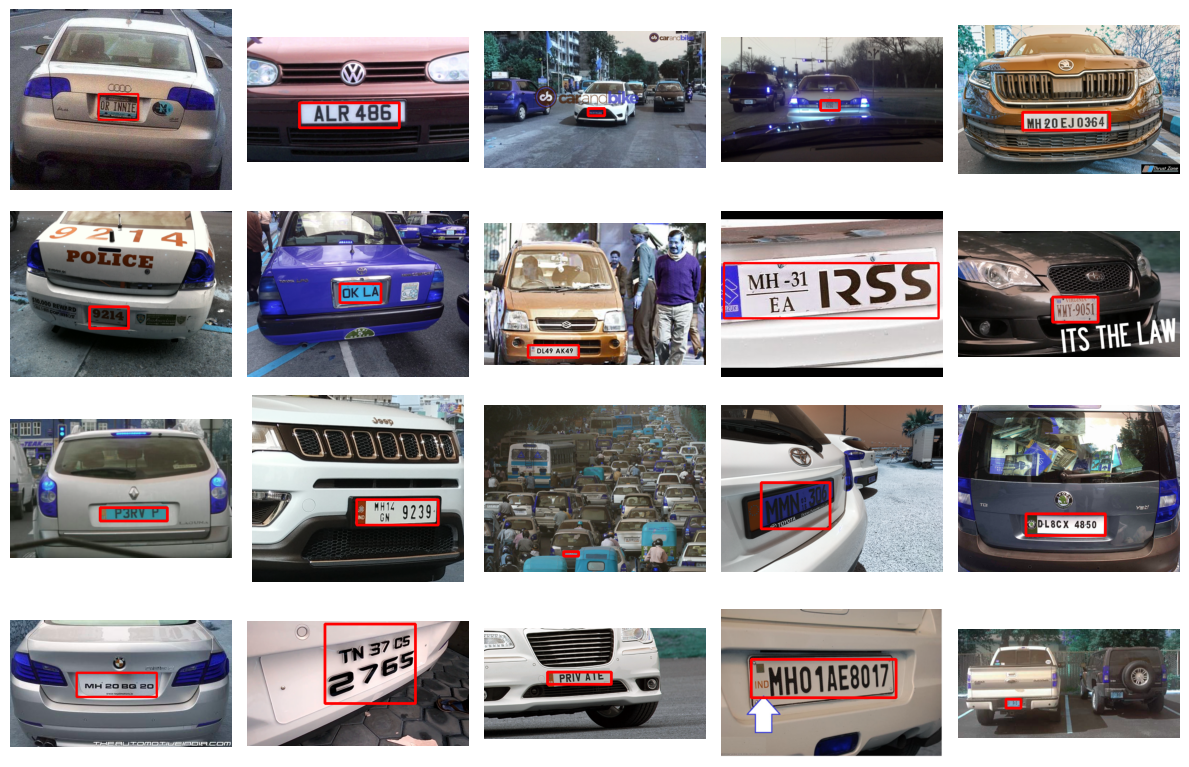

In [ ]:
plot_random_images_from_folder(folder_path= '/content/drive/MyDrive/Colab Notebooks/train/images',
                               num_images=20,
                               seed=CFG.seed)

In [ ]:
! wandb disabled

/bin/bash: line 1: wandb: command not found


In [ ]:
plate_model = YOLO(CFG.weights)

100%|██████████| 21.5M/21.5M [00:00<00:00, 156MB/s]


In [ ]:
train_device, test_device = gpu_report()
plate_model.to(train_device)

print('\nModel Info')
print('Model: ', CFG.weights)
print('Device: ' ,plate_model.device)

Number of available GPUs: 1

GPU 0: Tesla T4
  Total Memory: 14.75 GB
  CUDA Version: 7.5


| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |

Model Info
Model:  yolov8s.pt
Device:  cuda:0


In [ ]:
%%time

### train
plate_model.train(
    data = '/content/drive/MyDrive/Colab Notebooks/data.yaml',

    task = 'detect',

    #imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.epochs,
    batch = CFG.batch_size,
    optimizer = CFG.optimizer,
    lr0 = CFG.lr,
    lrf = CFG.lr_factor,
    weight_decay = CFG.weight_decay,
    dropout = CFG.dropout,
    patience = CFG.patience,
    label_smoothing = CFG.label_smoothing,
    imgsz = 640,#CFG.img_size,

    name = CFG.exp_name,
    seed = CFG.seed,
    profile = False,

    val = True,
    amp = False,   #mixed precision
    exist_ok = False, #overwrite experiment
    resume = False,
    device = train_device,
    verbose = False,
    single_cls = False,
)

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Colab Notebooks/data.yaml, epochs=50, time=None, patience=35, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=car_plate_detection2, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.5, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

train: Scanning /content/drive/MyDrive/Colab Notebooks/train/labels.cache... 383 images, 0 backgrounds, 0 corrupt: 100%|██████████| 383/383 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/valid/labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/car_plate_detection2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.7G      1.008     0.6059       1.09         28        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         50         50      0.809      0.849      0.838      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.8G      1.101     0.6409      1.151         29        640: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         50         50      0.829      0.776      0.823      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.8G      1.121     0.6878      1.152         26        640: 100%|██████████| 24/24 [00:14<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         50         50      0.778        0.8      0.849      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.8G      1.219     0.7494      1.188         38        640: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         50         50      0.729       0.88      0.837      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.8G      1.159     0.7405      1.164         35        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         50         50      0.734       0.82      0.803       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.8G       1.24     0.7694      1.213         32        640: 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         50         50       0.73        0.8      0.769      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.8G      1.196     0.7794      1.184         31        640: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         50         50      0.828      0.769      0.775      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.8G      1.248     0.7783      1.217         24        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         50         50      0.692       0.76      0.763      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.8G      1.182     0.7505      1.213         30        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         50         50      0.839       0.82      0.839      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.8G      1.289     0.7602      1.238         33        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         50         50      0.836       0.78      0.815      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.8G      1.152      0.704      1.188         29        640: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         50         50      0.804       0.66      0.789      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.8G       1.25     0.7446      1.205         29        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         50         50      0.813      0.784      0.827      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.8G      1.149     0.7084      1.153         25        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         50         50      0.823      0.835      0.775       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.8G       1.16     0.7178       1.16         27        640: 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         50         50      0.873        0.8       0.85      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.8G      1.178     0.7102      1.177         26        640: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         50         50      0.798      0.792      0.841      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.8G       1.13     0.6965      1.165         32        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         50         50      0.802       0.82      0.841      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.8G      1.133     0.6816      1.154         33        640: 100%|██████████| 24/24 [00:16<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         50         50       0.77      0.803      0.824      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.8G      1.126     0.6586      1.126         28        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         50         50      0.805       0.82      0.839       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.8G      1.114     0.6577      1.145         27        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         50         50      0.889        0.8      0.834      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.8G      1.104     0.6763      1.137         37        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         50         50      0.922       0.76      0.859      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.8G      1.094     0.6517      1.159         25        640: 100%|██████████| 24/24 [00:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         50         50      0.902       0.76      0.848       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.8G      1.078      0.632      1.112         22        640: 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         50         50      0.794       0.86      0.852      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      11.8G      1.098     0.6509      1.146         26        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

                   all         50         50      0.832       0.82      0.856      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      11.8G      1.055      0.616      1.116         29        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         50         50      0.802       0.78      0.818      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.8G      1.032     0.6198      1.118         27        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         50         50      0.792      0.837       0.83      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.8G      1.089     0.6448      1.127         29        640: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         50         50      0.751      0.845      0.834      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.8G     0.9935     0.5788      1.074         22        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         50         50      0.776       0.84      0.788      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.8G     0.9961      0.585      1.096         29        640: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         50         50      0.948      0.736      0.832       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      11.8G      1.005     0.5744      1.077         28        640: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         50         50      0.905      0.765      0.852      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.8G      0.988     0.5595      1.082         26        640: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         50         50      0.756       0.87      0.847      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.8G      1.023     0.5608      1.096         27        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         50         50      0.884        0.8      0.851      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.8G      1.007     0.5647      1.078         28        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         50         50      0.773       0.86      0.867      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.8G     0.9981     0.5736      1.113         26        640: 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         50         50      0.822      0.831      0.844      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.8G     0.9385     0.5487      1.084         21        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         50         50      0.808      0.841      0.823      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.8G     0.9408      0.524      1.055         25        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         50         50      0.876       0.78      0.823      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.8G     0.9387      0.554      1.075         36        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         50         50      0.843      0.751      0.834      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.8G     0.9696     0.5542      1.081         26        640: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         50         50      0.861       0.74      0.799      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.8G     0.9575     0.5531      1.076         26        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         50         50      0.747        0.8      0.794      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.8G     0.9354     0.5286       1.05         27        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         50         50      0.763      0.836      0.805      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.8G     0.9209     0.5143      1.083         24        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         50         50      0.825        0.8       0.83      0.459


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.8G     0.9396     0.5062      1.072         13        640: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         50         50      0.807       0.78      0.836       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.8G     0.8838     0.4817      1.049         15        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

                   all         50         50      0.792      0.836       0.83      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      11.8G     0.9009     0.4893      1.054         15        640: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         50         50      0.849      0.788      0.822      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.8G     0.8784       0.47      1.041         15        640: 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         50         50      0.835      0.807      0.842       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      11.8G     0.8541     0.4592      1.051         14        640: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         50         50      0.855       0.84      0.854      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.8G     0.8694     0.4612      1.035         15        640: 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         50         50      0.826        0.8      0.844      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.8G     0.8575     0.4476      1.044         15        640: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         50         50      0.769       0.82      0.826      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.8G     0.8425     0.4476      1.024         15        640: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         50         50      0.786      0.809      0.839      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.8G     0.8351      0.432       1.02         14        640: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         50         50      0.845       0.82      0.858      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.8G     0.8526     0.4405       1.05         15        640: 100%|██████████| 24/24 [00:14<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         50         50      0.849       0.82      0.854      0.503



50 epochs completed in 0.241 hours.
Optimizer stripped from runs/detect/car_plate_detection2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/car_plate_detection2/weights/best.pt, 22.5MB

Validating runs/detect/car_plate_detection2/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


                   all         50         50      0.884        0.8      0.853       0.52
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/car_plate_detection2
CPU times: user 8min 17s, sys: 1min 6s, total: 9min 23s
Wall time: 14min 48s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d443c397880>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
plate_model.export(
    format = 'openvino', # openvino, onnx, engine, tflite
    imgsz = 640,#CFG.img_size,
    half = False,#fp16
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs/detect/car_plate_detection2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 82.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.0s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 10.2s, saved as 'runs/detect/car_plate_detection2/weights/best.onnx' (42.6 MB)
requirements: Ultralytics requirement ['openvino-dev>=2023.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 21.1 MB/s eta 0:00:00
  Preparing 

'runs/detect/car_plate_detection2/weights/best_openvino_model'

In [ ]:
res_path = '/content/runs/detect'

In [ ]:
plots_path = [f for f in os.listdir(res_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

batchs_plot = [f for f in plots_path if 'val_batch' in f]
curves_plot = [f for f in plots_path if 'curve' in f]

print('Examples BBOX ')
for path in batchs_plot:
    print(''.join(path.split('/')))
    display_image(os.path.join(res_path,path), hide_axis = True)


Examples BBOX 


In [ ]:
!pip install Pillow

In [ ]:

from PIL import Image
print('Curves Metrics')
for path in curves_plot:
    print(''.join(path.split('/')))
    display_image(os.path.join(res_path,path), hide_axis = True)

Curves Metrics


In [ ]:
vehicle_model = YOLO(CFG.weights)
reader = easyocr.Reader(['en'],  gpu=True if test_device != 'cpu' else False)

plate_model.to(test_device)
vehicle_model.to(test_device)

print('\nModels Info')
print('Plate Model: ', plate_model.device, 'Vehicle Model: ', plate_model.device)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Models Info
Plate Model:  cuda:0 Vehicle Model:  cuda:0


In [ ]:
dict_all_classes = vehicle_model.model.names
dict_classes = {}
for id_class in CFG.vehicles_class:
    dict_classes[id_class] = dict_all_classes[id_class]

dict_classes

{2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}

In [ ]:
test_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/Data_add_pj1/train/images/*.jpg')


In [ ]:
pl_model = YOLO('/content/drive/MyDrive/rundata1/detect/car_plate_detection/weights/best.pt')

In [ ]:
def run_pipeline(path, display=False):

    '''
    1. Detect vehicles from a input image.
    2. Crop the ROIs with BBOX of vehicles detections.
    3. Detect plates from croped vehicle images.
    4. Crop the ROIs with BBOX of plate detections.
    5. Extract the plate number with OCR from croped plate detections.
    '''

    image = cv2.imread(path)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Input Image')

    #1
    vehicle_results = vehicle_model.predict(image,
                            conf =CFG.vehicle_conf,
                            classes = CFG.vehicles_class,
                            device = test_device,
                            verbose = False,

                                 )

    df_vehicles = pd.DataFrame(vehicle_results[0].cpu().numpy().boxes.data,
                                   columns = ['xmin', 'ymin', 'xmax',
                                              'ymax','conf', 'class'])
    df_vehicles['class'] = df_vehicles['class'].replace(dict_classes)


    # 2, 3,4
    image, df_plates = inference_inside_roi(df_vehicles,
                                                image,
                                                pl_model,
                                                test_device,
                                                display = display)
    df_frame = pd.concat([df_vehicles, df_plates], axis = 0).reset_index(drop=True)
    #Draw results in output images
    image = drawBBox(df_frame, image, thickness=5)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Output Image')

    return df_frame, image

/content/drive/MyDrive/Colab Notebooks/Data_add_pj1/31.png


/content/drive/MyDrive/Colab Notebooks/Data_add_pj1/1.png


Type:  <class 'PIL.Image.Image'> 

Shape:  (267, 400, 3) 



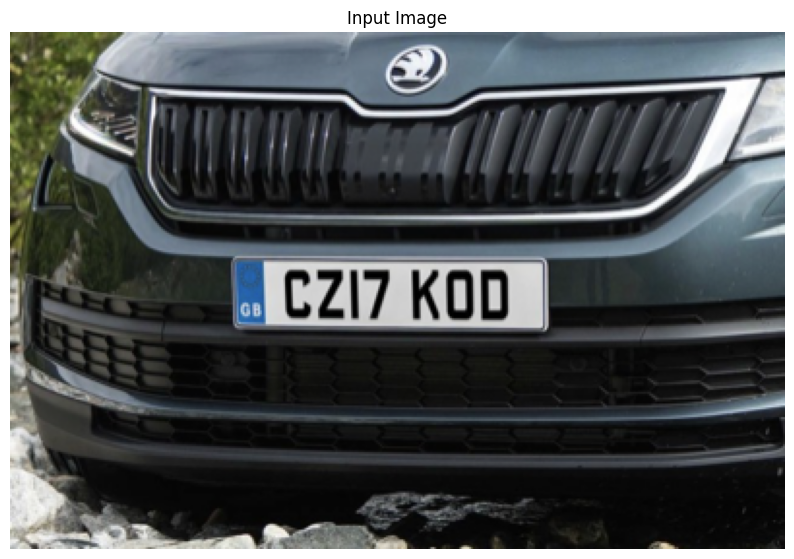

WARNING ⚠️ NMS time limit 0.550s exceeded
Type:  <class 'PIL.Image.Image'> 

Shape:  (244, 393, 3) 



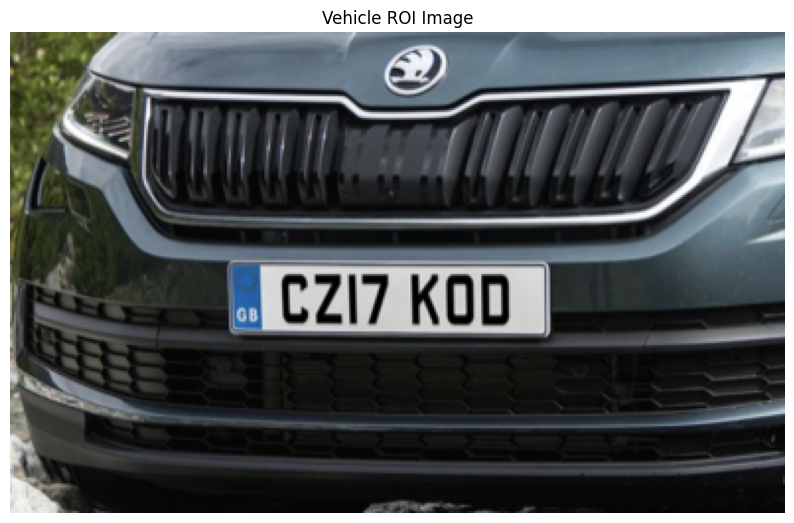

Type:  <class 'PIL.Image.Image'> 

Shape:  (44, 161, 3) 



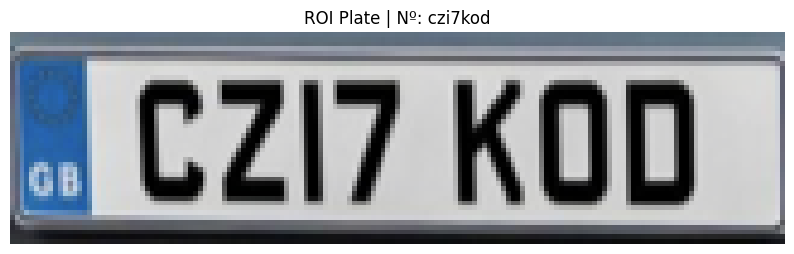

Type:  <class 'PIL.Image.Image'> 

Shape:  (267, 400, 3) 



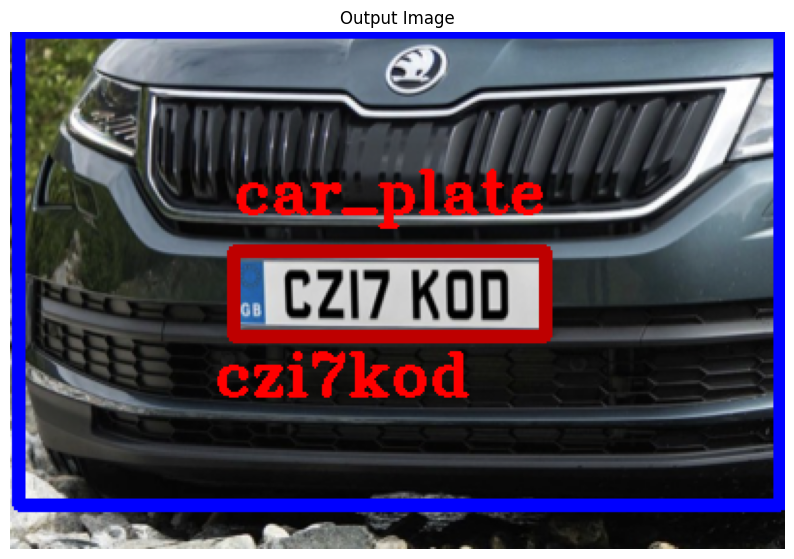

In [ ]:
df_frame, out_image  = run_pipeline(path ='/content/drive/MyDrive/Colab Notebooks/valid/images/Cars109.png', display=True)